## Домашнее задание к уроку 5<a class='anchor' id='hw'>

In [14]:
# Загрузка необходимых библиотек

import numpy as np
import random

import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split

1. Сформировать с помощью sklearn.make_classification датасет из 100 объектов с двумя признаками, обучить случайный лес из 1, 3, 10 и 50 деревьев и визуализировать их разделяющие гиперплоскости на графиках (по подобию визуализации деревьев из предыдущего урока, необходимо только заменить вызов функции predict на tree_vote).

In [4]:
# Определение data и labels для classification

classification_data, classification_labels = make_classification(
    n_samples = 100,
    n_features = 2,
    n_informative = 2,
    n_classes = 2,
    n_redundant = 0,
    n_clusters_per_class = 1,
    random_state = 23)

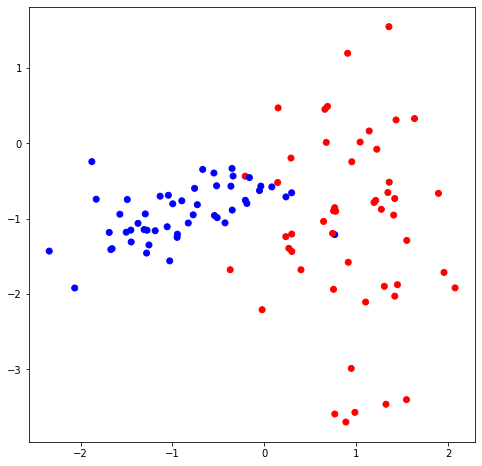

In [5]:
# Визуализация данных

colors = ListedColormap(['red', 'blue'])
light_colors = ListedColormap(['lightcoral', 'lightblue'])

plt.figure(figsize = (8,8))
plt.scatter(
    classification_data[:, 0], 
    classification_data[:, 1], 
    c = classification_labels, 
    cmap = colors);

In [6]:
# Поиск разбиения в узле через генерацию bootstrap выборок и подмножества признаков

seed = 42

np.random.seed(seed)

def get_bootstrap(data, labels, n):
    
    n_samples = data.shape[0]
    bootstrap = []
    
    for i in range(n):
        
        sample_index = np.random.randint(0, n_samples, size = n_samples)
        b_data = data[sample_index]
        b_labels = labels[sample_index]
        bootstrap.append((b_data, b_labels))
        
    return bootstrap

In [7]:
# Проверка

get_bootstrap(classification_data, classification_labels, 2)

[(array([[-0.37124564, -1.67679697],
         [-0.51278018, -0.98556015],
         [-0.54813278, -0.39241207],
         [-0.94885569, -1.24713565],
         [ 0.1502772 ,  0.47273166],
         [ 0.39895961, -1.67752215],
         [ 2.07599128, -1.91770526],
         [ 0.7432376 , -1.19378765],
         [ 1.63478531,  0.33127428],
         [ 1.63478531,  0.33127428],
         [ 0.2357014 , -0.70960755],
         [-1.50248523, -1.17842831],
         [ 0.29776211, -0.65527205],
         [ 0.23440873, -1.23792282],
         [ 0.75356225, -1.93718584],
         [ 1.5505173 , -1.28773359],
         [ 0.75362536, -0.89523588],
         [ 0.2357014 , -0.70960755],
         [-0.42752956, -1.05442826],
         [ 1.40819172, -0.95107001],
         [ 0.75362536, -0.89523588],
         [-1.57180854, -0.93984594],
         [ 0.67432897,  0.01459861],
         [ 0.39895961, -1.67752215],
         [-0.363129  , -0.56729178],
         [ 0.76616762, -0.85256618],
         [ 1.19398453, -0.7826786 ],
 

In [8]:
# Функция для sub sample с целью сохранять индексы от признаков

def get_subsample(len_sample):

    sample_indexes = list(range(len_sample))
    len_subsample = int(np.sqrt(len_sample))
    subsample = np.random.choice(sample_indexes, size = len_subsample, replace = False)

    return subsample

In [9]:
# Проверка

get_subsample(10)

array([5, 7, 6])

**Классы из предыдущего урока с изменениями**

In [10]:
# Реализация класса Node

class Node:
    
    def __init__(self, index, t, true_branch, false_branch):
        
        # Индекс признака, по которому ведется сравнение с порогом в этом узле
        self.index = index
        
        # Значение порога
        self.t = t
        
        # Поддерево, удовлетворяющее условию в узле
        self.true_branch = true_branch  
        
        # Поддерево, не удовлетворяющее условию в узле
        self.false_branch = false_branch

In [11]:
# Реализация класса Leaf

class Leaf:
    
    def __init__(self, data, labels):
        self.data = data
        self.labels = labels
        self.prediction = self.predict()
        
    def predict(self):
        
        # Подсчет количества объектов разных классов
        # Сформируем словарь "класс: количество объектов"
        
        classes = {}
        
        for label in self.labels:
            
            if label not in classes:
                
                classes[label] = 0
                
            classes[label] += 1
            
        # Найдем класс, количество объектов которого будет максимальным в этом листе и вернем его
        
        prediction = max(classes, key=classes.get)
        
        return prediction

**Дальнейшие функции**

In [13]:
# Джини

def gini(labels):
    #  подсчет количества объектов разных классов
    classes = {}
    for label in labels:
        if label not in classes:
            classes[label] = 0
        classes[label] += 1
    
    #  расчет критерия
    impurity = 1
    for label in classes:
        p = classes[label] / len(labels)
        impurity -= p ** 2
        
    return impurity


# Прирост

def gain(left_labels, right_labels, root_gini):

    # Доля выборки, ушедшая в левое поддерево
    
    p = float(left_labels.shape[0]) / (left_labels.shape[0] + right_labels.shape[0])
    
    return root_gini - p * gini(left_labels) - (1 - p) * gini(right_labels)


# Разбиение датасета в узле

def split(data, labels, column_index, t):
    
    left = np.where(data[:, column_index] <= t)
    right = np.where(data[:, column_index] > t)
        
    true_data = data[left]
    false_data = data[right]
    
    true_labels = labels[left]
    false_labels = labels[right]
        
    return true_data, false_data, true_labels, false_labels


# Поиск наилучшего разбиения

def find_best_split(data, labels):
    
    #  Обозначим минимальное количество объектов в узле
    
    min_leaf_samples = 5

    root_gini = gini(labels)

    best_gain = 0
    best_t = None
    best_index = None
    
    n_features = data.shape[1]
    
    feature_subsample_indices = get_subsample(n_features) 
    
    # Выбираем случайные признаки
    
    for index in feature_subsample_indices:
        
        # Будем проверять только уникальные значения признака, исключая повторения
        
        t_values = np.unique(data[:, index])
        
        for t in t_values:
            
            true_data, false_data, true_labels, false_labels = split(data, labels, index, t)
            
            current_gain = gain(true_labels, false_labels, root_gini)
            
            #  Выбираем порог, на котором получается максимальный прирост качества
            
            if current_gain > best_gain:
                best_gain, best_t, best_index = current_gain, t, index

    return best_gain, best_t, best_index


# Построение с помощью рекурсивной функции

def build_tree(data, labels):

    gain, t, index = find_best_split(data, labels)

    #  Базовый случай - прекращаем рекурсию, когда нет прироста в качества
    
    if gain == 0:
        
        return Leaf(data, labels)

    true_data, false_data, true_labels, false_labels = split(data, labels, index, t)

    # Рекурсивно строим два поддерева
    
    true_branch = build_tree(true_data, true_labels)
    false_branch = build_tree(false_data, false_labels)

    # Возвращаем класс узла со всеми поддеревьями, то есть целого дерева
    
    return Node(index, t, true_branch, false_branch)


# Функция для random forest

def random_forest(data, labels, n_trees):
    
    forest = []
    bootstrap = get_bootstrap(data, labels, n_trees)
    
    for b_data, b_labels in bootstrap:
        
        forest.append(build_tree(b_data, b_labels))
        
    return forest

# Функция для классификации отдельного объекта

def classify_object(obj, node):

    #  Останавливаем рекурсию, если достигли листа
    
    if isinstance(node, Leaf):
        
        answer = node.prediction
        
        return answer

    if obj[node.index] <= node.t:
        
        return classify_object(obj, node.true_branch)
    
    else:
        
        return classify_object(obj, node.false_branch)
    
# Predict 

def predict(data, tree):
    
    classes = []
    
    for obj in data:
        
        prediction = classify_object(obj, tree)
        classes.append(prediction)
        
    return classes

# Предсказание голосованием деревьев

def tree_vote(forest, data):

    # Добавим предсказания всех деревьев в список
    
    predictions = []
    
    for tree in forest:
        
        predictions.append(predict(data, tree))

    # Сформируем список с предсказаниями для каждого объекта
    
    predictions_per_object = list(zip(*predictions))

    # Выберем в качестве итогового предсказания для каждого объекта то, за которое проголосовало большинство деревьев
    
    voted_predictions = []
    
    for obj in predictions_per_object:
        
        voted_predictions.append(max(set(obj), key=obj.count))
        
    return voted_predictions

In [15]:
# Train test split

train_data, test_data, train_labels, test_labels = train_test_split(classification_data, classification_labels, test_size = 0.3, random_state = 1)

In [16]:
# Accuracy

def accuracy_metric(actual, predicted):
    
    correct = 0
    
    for i in range(len(actual)):
        
        if actual[i] == predicted[i]:
            
            correct += 1
            
    return correct / float(len(actual)) * 100.0

**Построение лесов с разным количеством деревьев**

In [18]:
# Построение леса - 1 дерево

n = 1

forest_1 = random_forest(train_data, train_labels, n)

# Голосование для обучающей и тестовой выборки

train_answers = tree_vote(forest_1, train_data)
test_answers = tree_vote(forest_1, test_data)

# Точность на обучении и тесте

train_accuracy = accuracy_metric(train_labels, train_answers)
print(f'Точность случайного леса из {n} деревьев на обучающей выборке: {train_accuracy:.3f}')

test_accuracy = accuracy_metric(test_labels, test_answers)
print(f'Точность случайного леса из {n} деревьев на тестовой выборке: {test_accuracy:.3f}')

Точность случайного леса из 1 деревьев на обучающей выборке: 97.143
Точность случайного леса из 1 деревьев на тестовой выборке: 86.667


In [19]:
# Построение леса - 3 дерева

n = 3

forest_3 = random_forest(train_data, train_labels, n)

# Голосование для обучающей и тестовой выборки

train_answers = tree_vote(forest_3, train_data)
test_answers = tree_vote(forest_3, test_data)

# Точность на обучении и тесте

train_accuracy = accuracy_metric(train_labels, train_answers)
print(f'Точность случайного леса из {n} деревьев на обучающей выборке: {train_accuracy:.3f}')

test_accuracy = accuracy_metric(test_labels, test_answers)
print(f'Точность случайного леса из {n} деревьев на тестовой выборке: {test_accuracy:.3f}')

Точность случайного леса из 3 деревьев на обучающей выборке: 95.714
Точность случайного леса из 3 деревьев на тестовой выборке: 83.333


In [20]:
# Построение леса - 10 деревьев

n = 10

forest_10 = random_forest(train_data, train_labels, n)

# Голосование для обучающей и тестовой выборки

train_answers = tree_vote(forest_10, train_data)
test_answers = tree_vote(forest_10, test_data)

# Точность на обучении и тесте

train_accuracy = accuracy_metric(train_labels, train_answers)
print(f'Точность случайного леса из {n} деревьев на обучающей выборке: {train_accuracy:.3f}')

test_accuracy = accuracy_metric(test_labels, test_answers)
print(f'Точность случайного леса из {n} деревьев на тестовой выборке: {test_accuracy:.3f}')

Точность случайного леса из 10 деревьев на обучающей выборке: 98.571
Точность случайного леса из 10 деревьев на тестовой выборке: 90.000


In [21]:
# Построение леса - 50 деревьев

n = 50

forest_50 = random_forest(train_data, train_labels, n)

# Голосование для обучающей и тестовой выборки

train_answers = tree_vote(forest_50, train_data)
test_answers = tree_vote(forest_50, test_data)

# Точность на обучении и тесте

train_accuracy = accuracy_metric(train_labels, train_answers)
print(f'Точность случайного леса из {n} деревьев на обучающей выборке: {train_accuracy:.3f}')

test_accuracy = accuracy_metric(test_labels, test_answers)
print(f'Точность случайного леса из {n} деревьев на тестовой выборке: {test_accuracy:.3f}')

Точность случайного леса из 50 деревьев на обучающей выборке: 100.000
Точность случайного леса из 50 деревьев на тестовой выборке: 83.333


In [22]:
# Функции для визуализации результата

def get_meshgrid(data, step = .05, border = 1.2):
    
    x_min, x_max = data[:, 0].min() - border, data[:, 0].max() + border
    y_min, y_max = data[:, 1].min() - border, data[:, 1].max() + border
    
    return np.meshgrid(np.arange(x_min, x_max, step), np.arange(y_min, y_max, step))


def visualize(forest, train_data, test_data):
    
    plt.figure(figsize = (16, 7))

    # Обучение
    
    plt.subplot(1,2,1)
    xx, yy = get_meshgrid(train_data)
    ggg = np.c_[xx.ravel(), yy.ravel()]
    mesh_predictions = np.array(tree_vote(forest, ggg)).reshape(xx.shape)
    plt.pcolormesh(xx, yy, mesh_predictions, cmap = light_colors)
    plt.scatter(train_data[:, 0], train_data[:, 1], c = train_labels, cmap = colors)
    plt.title(f'Train accuracy={train_accuracy:.2f}')

    # Тест
    
    plt.subplot(1,2,2)
    plt.pcolormesh(xx, yy, mesh_predictions, cmap = light_colors)
    plt.scatter(test_data[:, 0], test_data[:, 1], c = test_labels, cmap = colors)
    plt.title(f'Test accuracy={test_accuracy:.2f}')

<ipython-input-22-671d0fe75735>:21: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  plt.pcolormesh(xx, yy, mesh_predictions, cmap = light_colors)
<ipython-input-22-671d0fe75735>:28: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  plt.pcolormesh(xx, yy, mesh_predictions, cmap = light_colors)


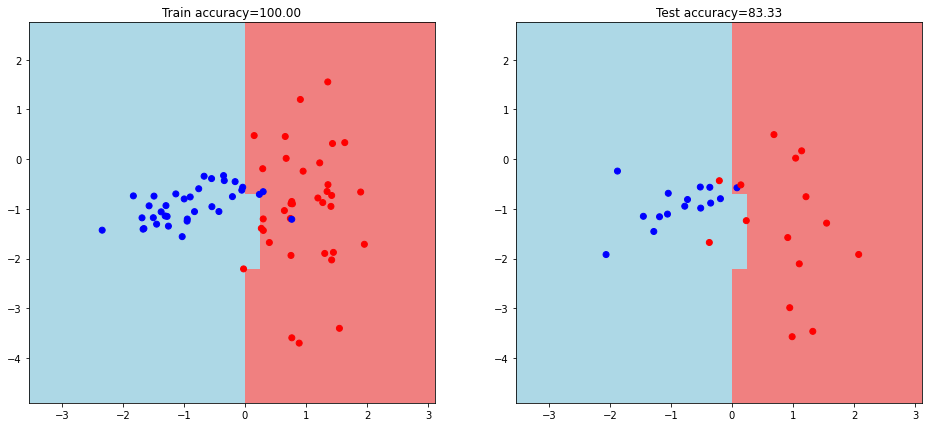

In [23]:
# Проверка для 1

visualize(forest_1, train_data, test_data)

<ipython-input-22-671d0fe75735>:21: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  plt.pcolormesh(xx, yy, mesh_predictions, cmap = light_colors)
<ipython-input-22-671d0fe75735>:28: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  plt.pcolormesh(xx, yy, mesh_predictions, cmap = light_colors)


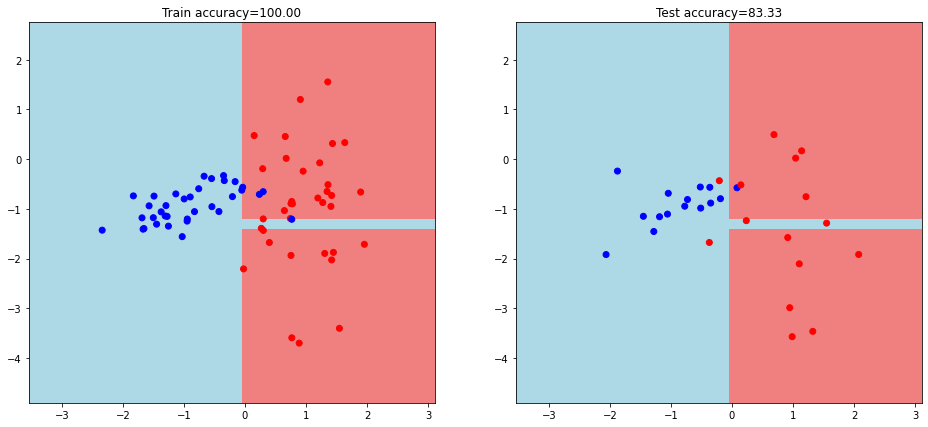

In [24]:
# Проверка для 3

visualize(forest_3, train_data, test_data)

<ipython-input-22-671d0fe75735>:21: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  plt.pcolormesh(xx, yy, mesh_predictions, cmap = light_colors)
<ipython-input-22-671d0fe75735>:28: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  plt.pcolormesh(xx, yy, mesh_predictions, cmap = light_colors)


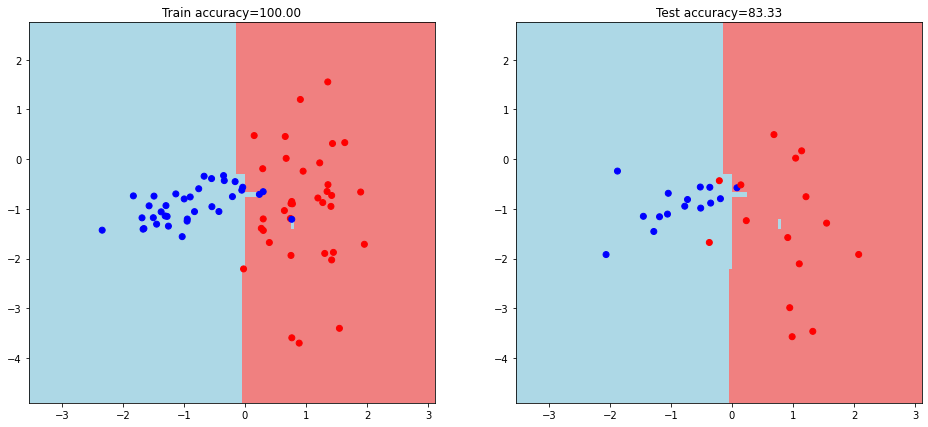

In [25]:
# Проверка для 10

visualize(forest_10, train_data, test_data)

<ipython-input-22-671d0fe75735>:21: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  plt.pcolormesh(xx, yy, mesh_predictions, cmap = light_colors)
<ipython-input-22-671d0fe75735>:28: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  plt.pcolormesh(xx, yy, mesh_predictions, cmap = light_colors)


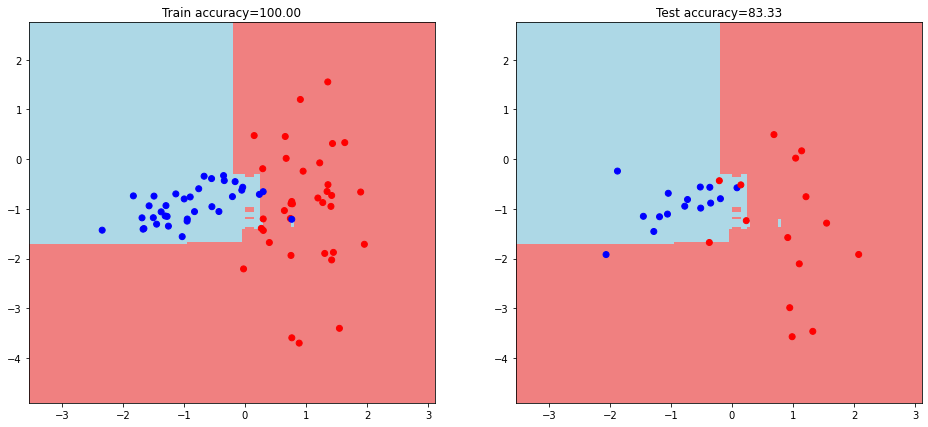

In [26]:
# Проверка для 50

visualize(forest_50, train_data, test_data)

2. Сделать выводы о получаемой сложности гиперплоскости и недообучении или переобучении случайного леса в зависимости от количества деревьев в нем.

**Мы можем заметить, что модель с 50 деревьями явно переобучилась**

---

3. *Заменить в реализованном алгоритме проверку с помощью отложенной выборки на Out-of-Bag.

4. *(На повторение) Переписать функцию gini из урока про решающие деревья так, чтобы в качестве критерия использовалась энтропия Шэннона. Переименовать функцию в entropy.